In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (13,10)
plt.style.use('bmh')
from datetime import timedelta
from keras.models import *
from keras.layers import *
from sklearn.preprocessing import *
from sklearn.linear_model import * 
import seaborn as sns
# from fbprophet import Prophet
# # from google.colab import drive 
# # drive.mount('/content/drive')

import os

# Load the dataset and quick preview

In [2]:
building = 'QB'

In [3]:
data = pd.read_csv('drive/MyDrive/Colab Notebooks/EnergyData/Preprocessed/'+building+'ElecWeatherDailyData.csv', index_col=0, parse_dates=True)
data.head()

,value,temp,dew_point,pressure,humidity,wind_speed
Datetime,,,,,,
2008-03-03,2401.768,4.422917,-0.175417,1010.041667,72.250000,5.371667
2008-03-04,3799.027,3.310000,-0.861250,1026.375000,75.208333,5.100000
2008-03-05,3874.801,4.049167,0.947083,1033.000000,80.291667,4.379167
2008-03-06,3799.476,9.252500,5.157500,1021.916667,75.791667,5.761250
2008-03-07,3738.969,7.638750,2.673333,1010.166667,71.750000,6.660833


In [4]:
data.describe()

,value,temp,dew_point,pressure,humidity,wind_speed
count,5112.000000,5112.000000,5112.000000,5112.000000,5112.000000,5112.000000
mean,2536.693891,10.450578,7.288458,1014.369938,81.968717,4.415995
std,661.905452,5.351245,4.738956,11.007041,8.490008,1.797710
min,457.500000,-6.250000,-6.898750,968.916667,53.083333,0.822917
25%,2064.414250,6.446667,3.754896,1007.708333,75.833333,3.082708
50%,2522.123500,10.483125,7.496667,1015.437500,82.375000,4.195000
75%,3009.061000,14.720104,11.012292,1021.802083,88.458333,5.531458
max,4203.074000,26.625417,18.644167,1047.125000,100.000000,12.804583


Lets check each feature values

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f260250afd0>,
      dtype=object)

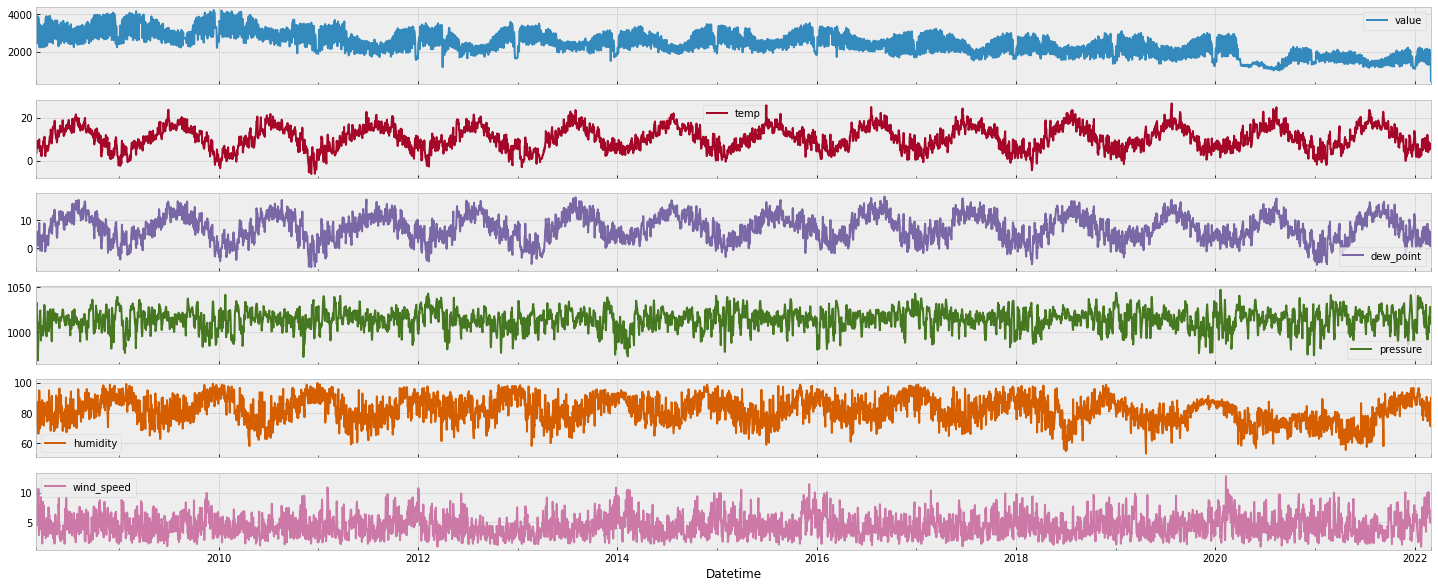

In [7]:
data.plot(subplots=True, figsize=(25,10))

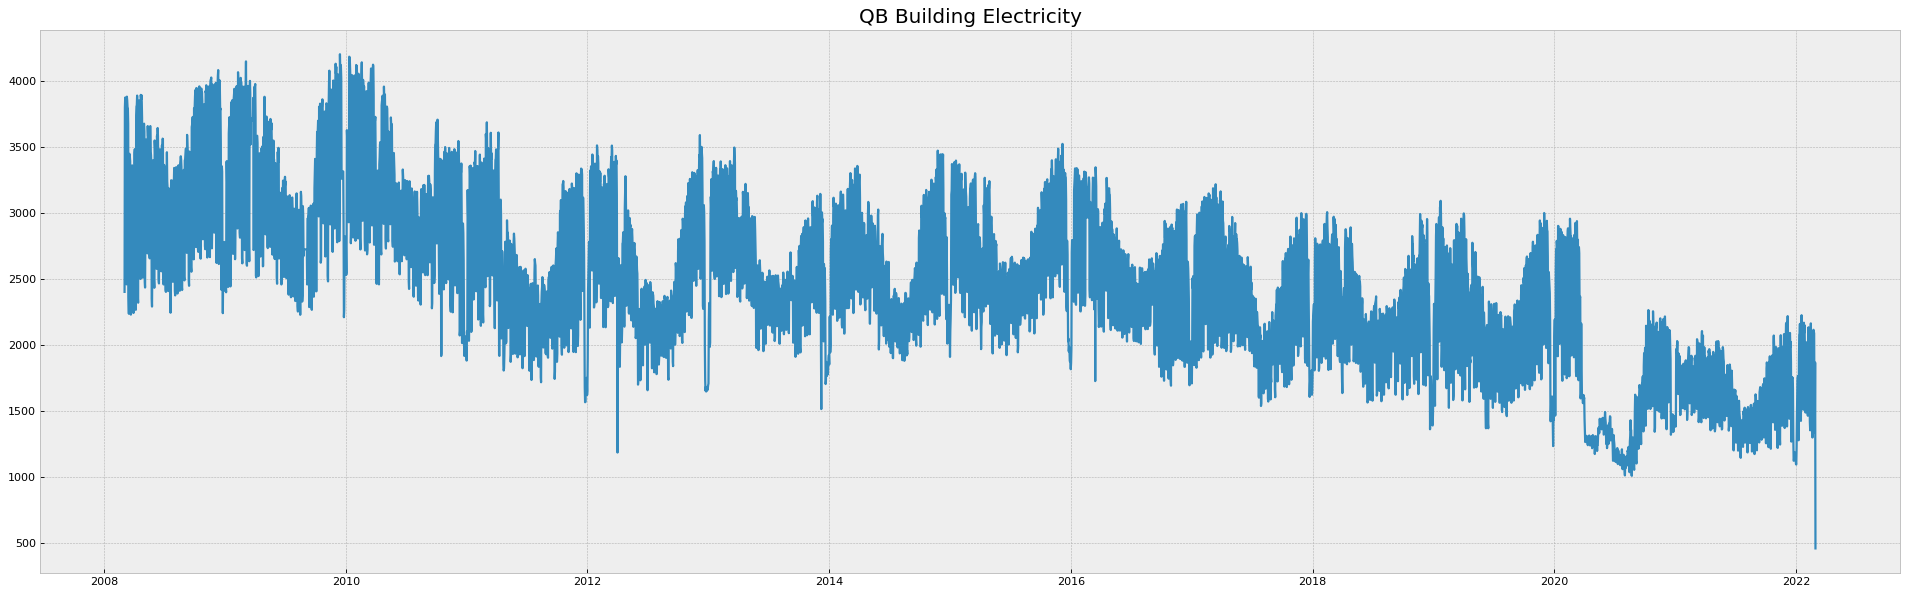

In [8]:
plt.figure(num=None, figsize=(30, 9), dpi=80, facecolor='w', edgecolor='k')
plt.title(building +' Building Electricity', fontsize=18)

plt.plot(data.value)
plt.savefig("drive/MyDrive/Colab Notebooks/EnergyData/Preprocessed/"+building+"_Daily_Elec.PNG")

# Decomposing our time series

<Figure size 1120x720 with 0 Axes>

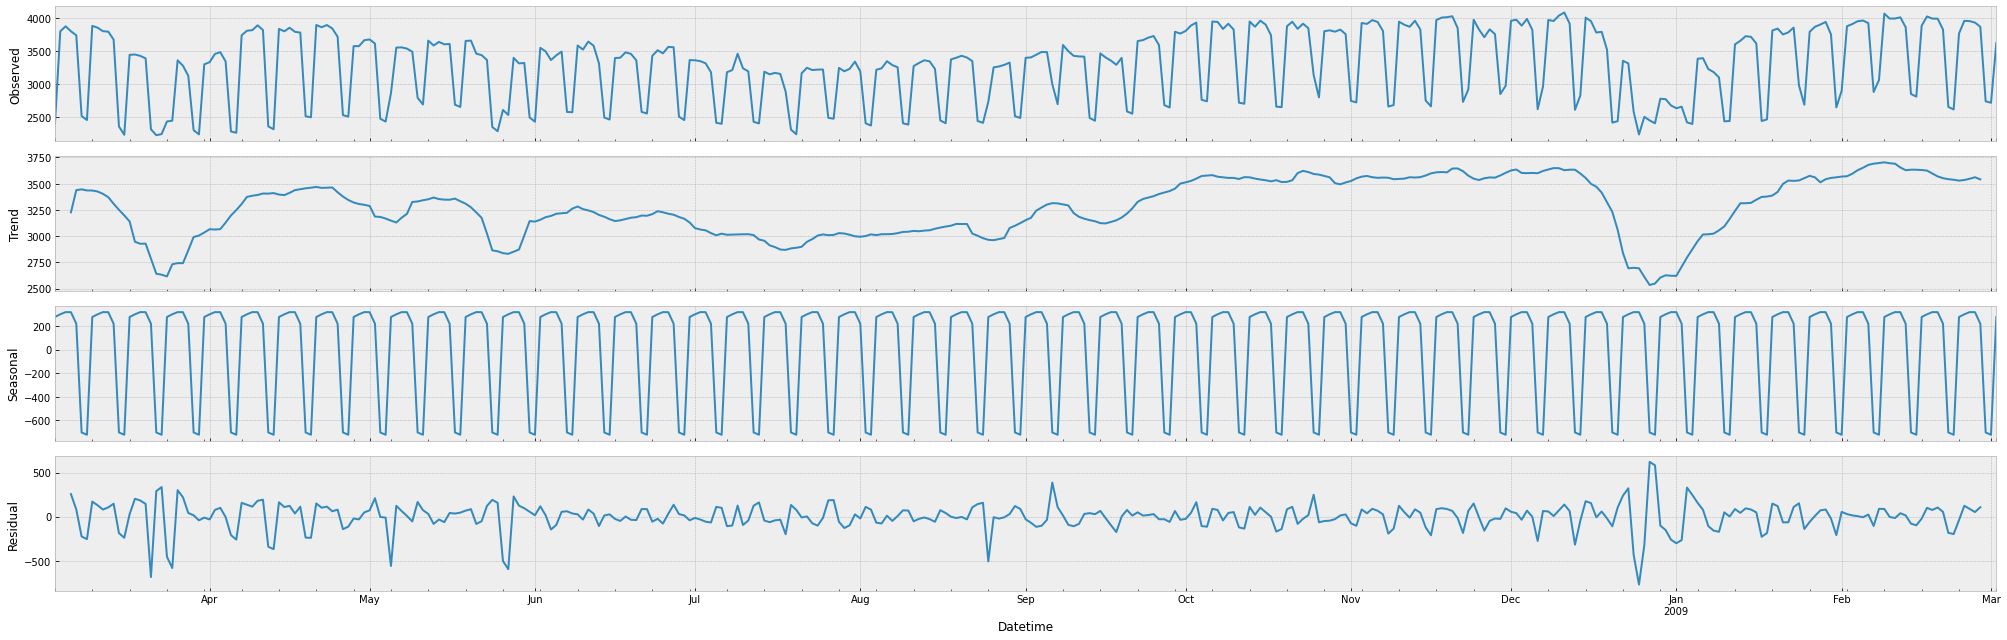

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams['figure.figsize'] = 28, 9
plt.figure(num=None, figsize=(14,9), dpi=80, facecolor='w', edgecolor='k')
series = data.value[:365]
result = seasonal_decompose(series)
result.plot();

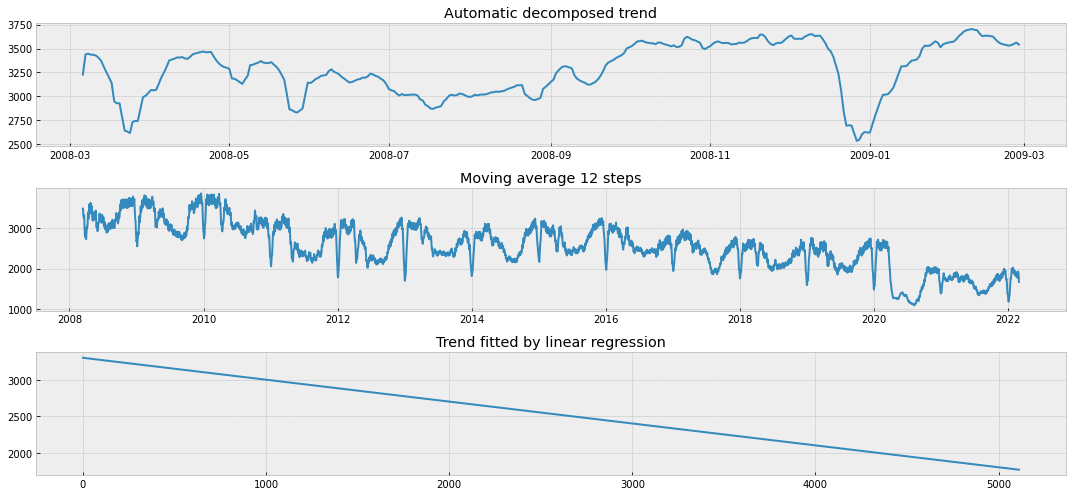

In [16]:
fig = plt.figure(figsize=(15, 7))
layout = (3, 2)
pm_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
mv_ax = plt.subplot2grid(layout, (1, 0), colspan=2)
fit_ax = plt.subplot2grid(layout, (2, 0), colspan=2)

pm_ax.plot(result.trend)
pm_ax.set_title("Automatic decomposed trend")

mm = data.value.rolling(12).mean()
mv_ax.plot(mm)
mv_ax.set_title("Moving average 12 steps")


X = [i for i in range(0, len(data.value))]
X = np.reshape(X, (len(X), 1))
y = data.value.values
model = LinearRegression()
model.fit(X, y)
# calculate trend
trend = model.predict(X)
fit_ax.plot(trend)
fit_ax.set_title("Trend fitted by linear regression")

plt.tight_layout()

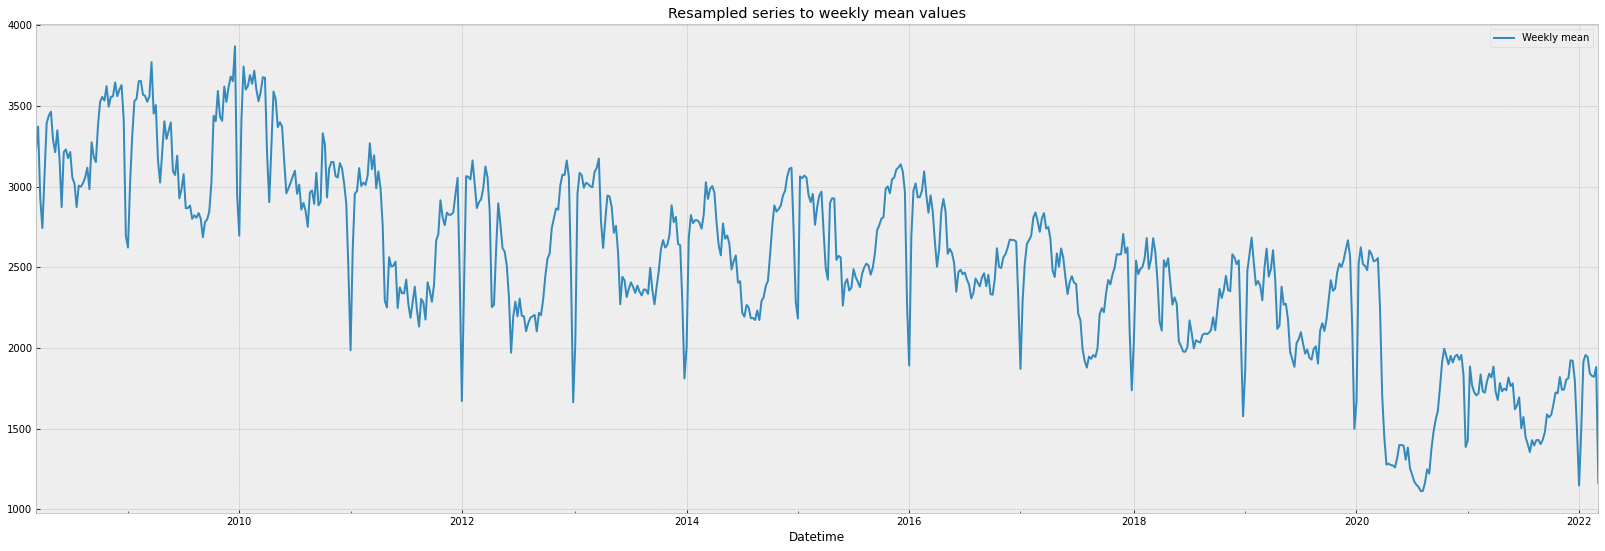

In [17]:
# Looking for weekly seasonality
resample = data.resample('W')
weekly_mean = resample.mean()
weekly_mean.value.plot(label='Weekly mean')
plt.title("Resampled series to weekly mean values")
plt.legend()

# Manual methods to find seasonalities

We can also try to generate a model to find the seasonalities for us. One of the most common to use is a simple polynomial model.

/usr/local/lib/python3.7/dist-packages/numpy/lib/polynomial.py:658: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


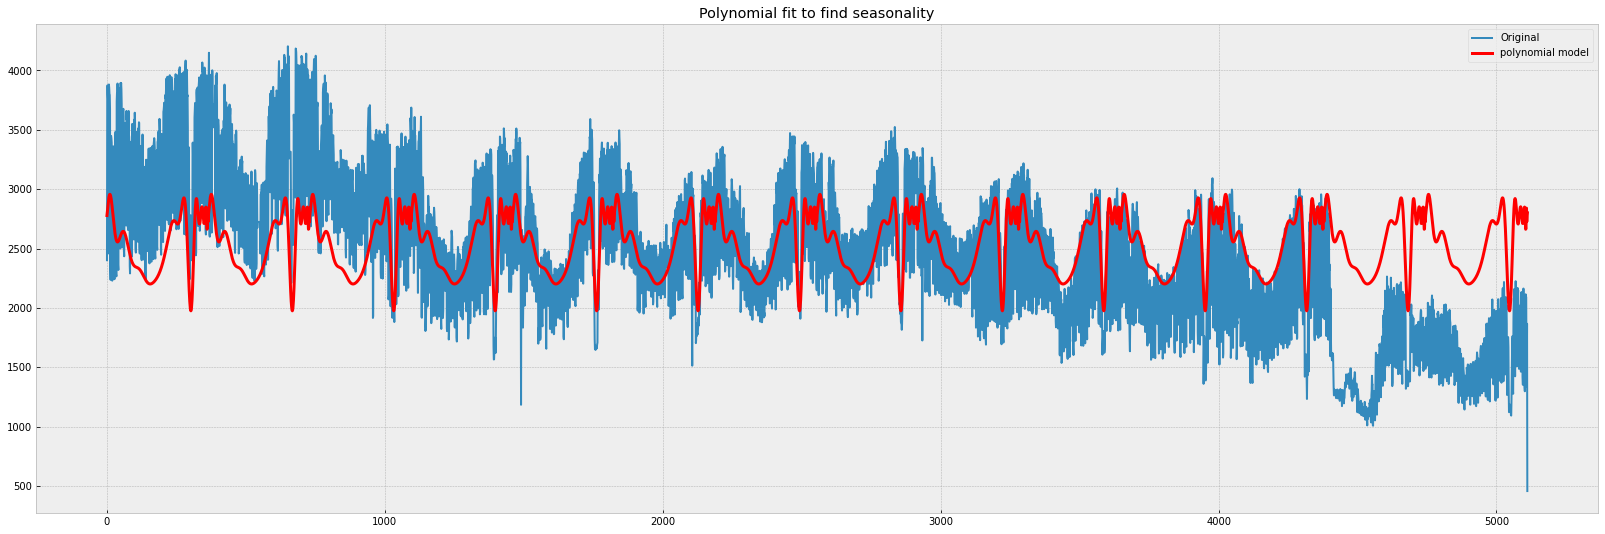

In [18]:
# Fix xticks to show dates
# fit polynomial: x^2*b1 + x*b2 + ... + bn
series = data.value.values
X = [i % 365 for i in range(0, len(series))]
y = series
degree = 100
coef = np.polyfit(X, y, degree)
# create curve
curve = list()
for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)
# plot curve over original data
plt.plot(series, label='Original')
plt.plot(curve, color='red', linewidth=3, label='polynomial model')
plt.legend()
plt.title("Polynomial fit to find seasonality")
plt.show()

# Noise
Our time series will also have a noise component to them, most likely white noise. We say white noise is present if the measurement are independent and identically distributed with a mean of zero. This will mean all our measurements have same variance and no correlation with the rest of values in the series.

If our time series has white noise this will mean we can't predict that component of the series (as is random) and we shoul aim to produce a model with errors close to this white noise.

How to check if our series has white noise?

- Check our series histogram, does it look like a Gaussian distribution? Mean=0 and constand std
- Correlation plots
- Standard deviation distribution, is it a Gaussian distribution?
- Does the mean or level change over time?

Text(0.5, 1.0, 'Mean over time')

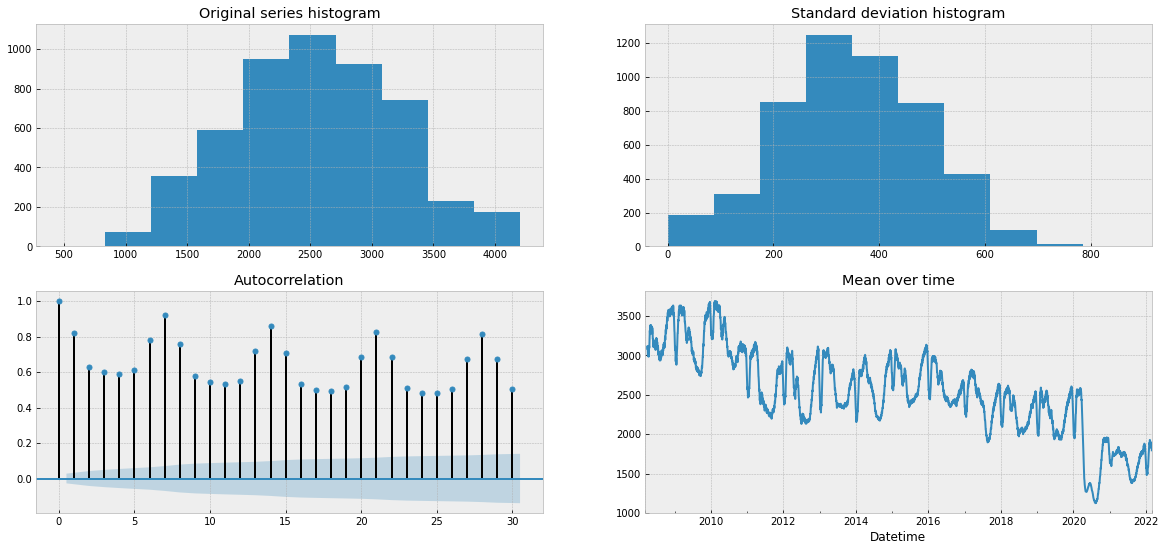

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plt.figure(figsize=(20, 9))
layout = (2, 2)
hist_ax = plt.subplot2grid(layout, (0, 0))
ac_ax = plt.subplot2grid(layout, (1, 0))
hist_std_ax = plt.subplot2grid(layout, (0, 1))
mean_ax = plt.subplot2grid(layout, (1, 1))

data.value.hist(ax=hist_ax)
hist_ax.set_title("Original series histogram")

plot_acf(series, lags=30, ax=ac_ax)
ac_ax.set_title("Autocorrelation")

mm = data.value.rolling(7).std()
mm.hist(ax=hist_std_ax)
hist_std_ax.set_title("Standard deviation histogram")

mm = data.value.rolling(30).mean()
mm.plot(ax=mean_ax)
mean_ax.set_title("Mean over time")

# Stationarity
Stationarity is an important characteristic of time series. A time series is stationarity if it has constant mean and variance over time. Most models work only with stationary data as this makes it easier to model. Not all time series are stationary but we can transform them into stationary series in different ways.

Often, stock prices are not a stationary process, since we might see a growing trend, or its volatility might increase over time (meaning that variance is changing).

## Check for sationarity
## Autocorrelation and Partial autocorrelation plots
Autocorelation plots show how correlated are values at time t with the next values in time t+1,t+2,..t+n. If the data would be non-stationary the autocorrelation values will be highly correlated with distant points in time showing possible seasonalities or trends.

Stationary series autocorrelation values will quickly decrease over time t. This shows us that no information is carried over time and then the series should be constant over time.

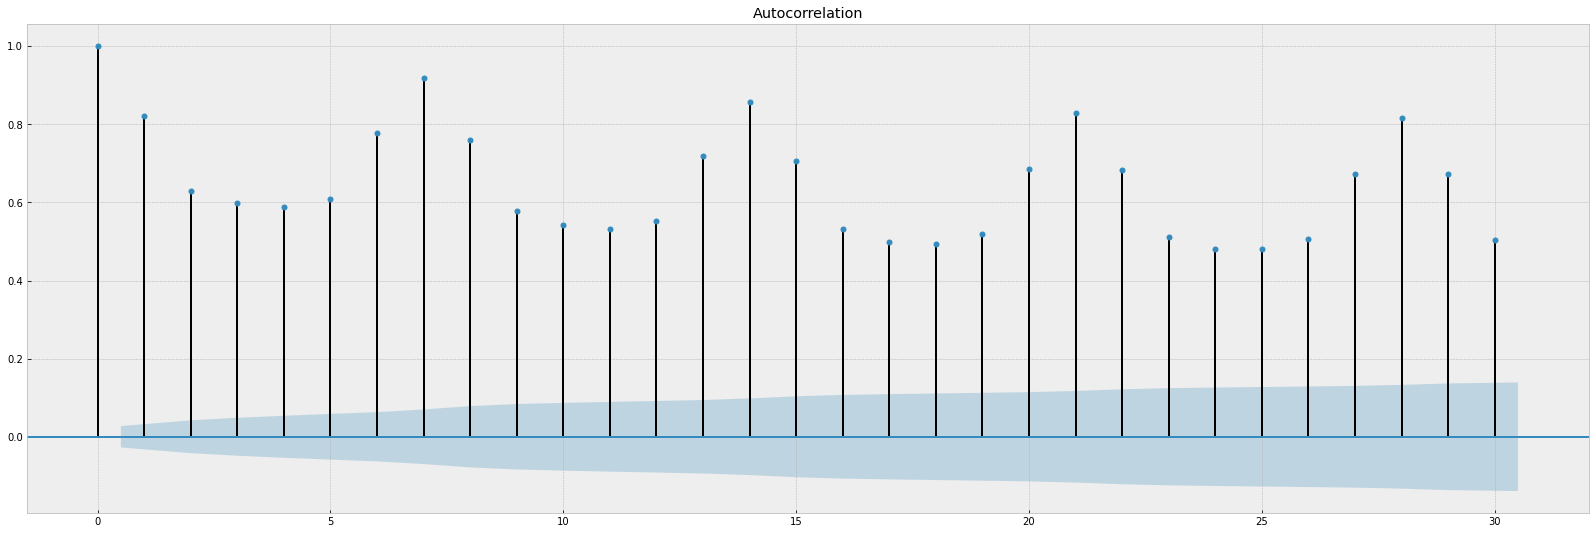

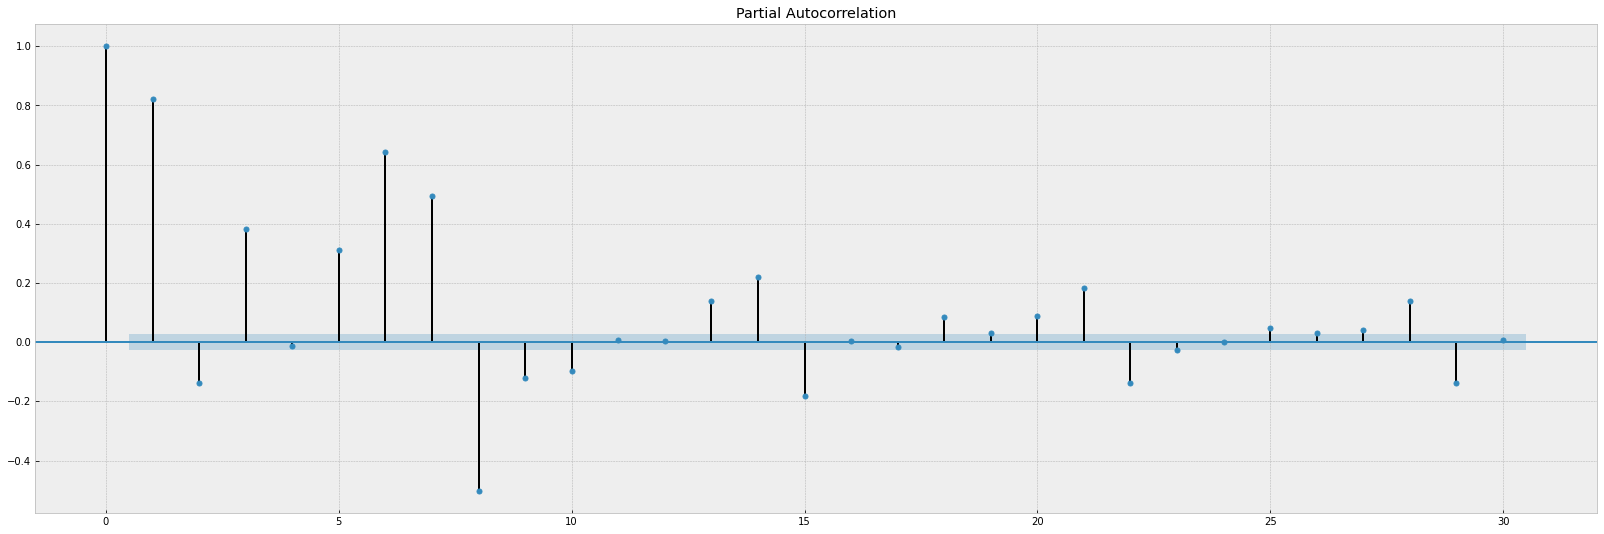

In [23]:
plot_acf(series, lags=30)
plot_pacf(series, lags=30)
plt.show()

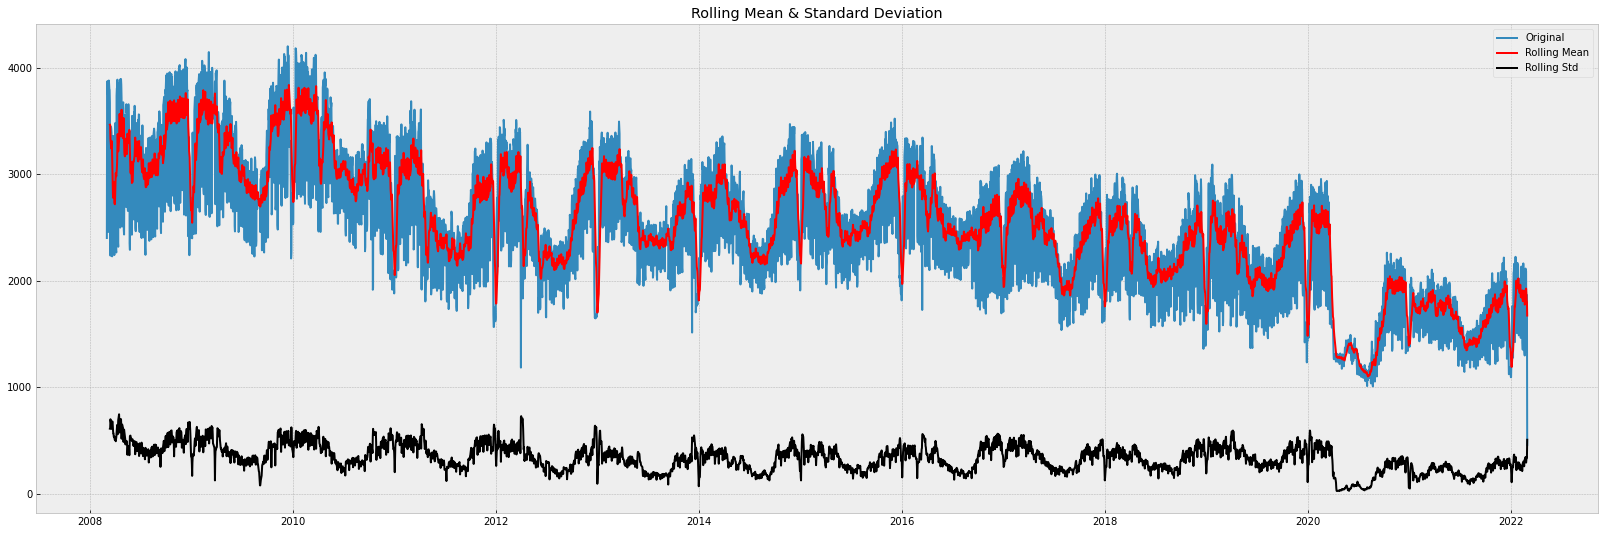

In [24]:
# Determing rolling statistics
rolmean = data.value.rolling(window=12).mean()
rolstd = data.value.rolling(window=12).std()

# Plot rolling statistics:
orig = plt.plot(data.value, label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

# Augmented Dickey-Fuller test

In [25]:
from statsmodels.tsa.stattools import adfuller

X = data.value.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.982600
p-value: 0.036552
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


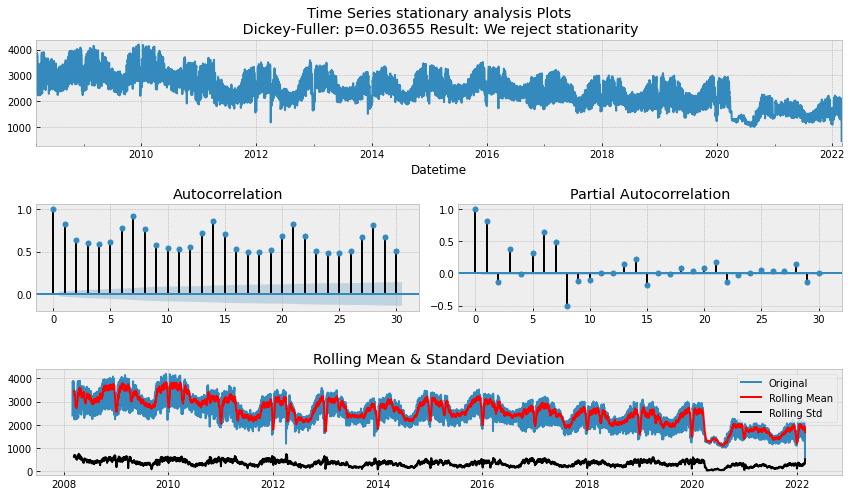

In [26]:
from statsmodels.tsa import api as smt
import statsmodels as sm

def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=(12, 7))
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        mean_std_ax = plt.subplot2grid(layout, (2, 0), colspan=2)
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        hypothesis_result = "We reject stationarity" if p_value <= 0.05 else "We can not reject stationarity"
        ts_ax.set_title(
            'Time Series stationary analysis Plots\n Dickey-Fuller: p={0:.5f} Result: {1}'.format(p_value, hypothesis_result))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

        rolmean = data.value.rolling(window=12).mean()
        rolstd = data.value.rolling(window=12).std()

        # Plot rolling statistics:
        orig = plt.plot(data.value, label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label='Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')


tsplot(data.value, lags=30)

# Methods for time series forecasting
There are many methods that we can use for time series forecasting and there is not a clear winner. Model selection should always depend on how you data look and what are you trying to achieve. Some models may be more robust against outliers but perform worse than the more sensible and could still be the best choice depending on the use case.

When looking at your data the main split is wether we have extra regressors (features) to our time series or just the series. Based on this we can start exploring different methods for forecasting and their performance in different metrics.

In this section we will show models for both cases, time series with and without extra regressors.

### Prepare data before modeling

In [28]:
# We split our dataset to be able to evaluate our models

resultsDict = {}
predictionsDict = {}

split_date = '2018-12-31'
df_training = data.loc[data.index <= split_date]
df_test = data.loc[data.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

3956 days of training data 
 1156 days of testing data 


In [29]:
from sklearn.metrics import *

In [30]:
def rmse(actual: np.ndarray, predicted: np.ndarray):
    """Root Mean Squared Error"""
    return np.sqrt(mean_squared_error(actual, predicted))

In [31]:
def mape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Absolute Percentage Error

    Properties:
        + Easy to interpret
        + Scale independent
        - Biased, not symmetric
        - Undefined when actual[t] == 0

    Note: result is NOT multiplied by 100
    """
    return mean_absolute_percentage_error(actual, predicted)

In [32]:
def mae(actual: np.ndarray, predicted: np.ndarray):
    """Mean Absolute Error"""
    return mean_absolute_error(actual, predicted)

In [33]:
METRICS = {
    "rmse": rmse,
    "mae": mae,
    "mape": mape,
    "r2": r2_score
}

In [34]:
def bar_metrics(resultsDict):
    df = pd.DataFrame.from_dict(resultsDict)
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    pallette = plt.cm.get_cmap("tab20c", len(df.columns))
    colors = [pallette(x) for x in range(len(df.columns))]
    color_dict = dict(zip(df.columns, colors))
    fig = plt.figure(figsize=(20, 15))

    # MAE plot
    fig.add_subplot(2, 2, 1)
    df.loc["mae"].sort_values().plot(
        kind="bar",
        colormap="Paired",
        color=[color_dict.get(x, "#333333") for x in df.loc["mae"].sort_values().index],
    )
    plt.legend()
    plt.title("MAE Metric, lower is better")
    fig.add_subplot(2, 2, 2)
    df.loc["rmse"].sort_values().plot(
        kind="bar",
        colormap="Paired",
        color=[
            color_dict.get(x, "#333333") for x in df.loc["rmse"].sort_values().index
        ],
    )
    plt.legend()
    plt.title("RMSE Metric, lower is better")
    fig.add_subplot(2, 2, 3)
    df.loc["mape"].sort_values().plot(
        kind="bar",
        colormap="Paired",
        color=[
            color_dict.get(x, "#333333") for x in df.loc["mape"].sort_values().index
        ],
    )
    plt.legend()
    plt.title("MAPE Metric, lower is better")
    fig.add_subplot(2, 2, 4)
    df.loc["r2"].sort_values(ascending=False).plot(
        kind="bar",
        colormap="Paired",
        color=[
            color_dict.get(x, "#333333")
            for x in df.loc["r2"].sort_values(ascending=False).index
        ],
    )
    plt.legend()
    plt.title("R2 Metric, higher is better")
    plt.tight_layout()
    plt.savefig("drive/MyDrive/Colab Notebooks/EnergyData/Preprocessed/"+building+"metrics.PNG")
    plt.show()

In [35]:
def evaluate(
    actual: np.ndarray, predicted: np.ndarray, metrics=("mae", "rmse", "mape", "r2")
):
    results = {}
    for name in metrics:
        try:
            results[name] = METRICS[name](actual, predicted)
        except Exception as err:
            results[name] = np.nan
            print("Unable to compute metric {0}: {1}".format(name, err))
    return results

# Prophet
Prophet is a model released by facebook. Is essentially a curve fitting approach, very similar in spirit to how BSTS models trend and seasonality, except that it uses generalized additive models instead of a state-space representation to describe each component.

In [36]:
# Prophet needs some specifics data stuff, coment it here
prophet_training = df_training.rename(columns={'value': 'y'})  # old method
prophet_training['ds'] = prophet_training.index
prophet_training.index = pd.RangeIndex(len(prophet_training.index))

prophet_test = df_test.rename(columns={'value': 'y'})  # old method
prophet_test['ds'] = prophet_test.index
prophet_test.index = pd.RangeIndex(len(prophet_test.index))

In [37]:
model = Prophet(daily_seasonality=True, interval_width=0.9)
# model.add_country_holidays(country_name='UK')

In [38]:
model.fit(prophet_training)
yhat = model.predict(prophet_test)
resultsDict['Prophet univariate'] = evaluate(df_test.value, yhat.yhat.values)
predictionsDict['Prophet univariate'] = yhat.yhat.values

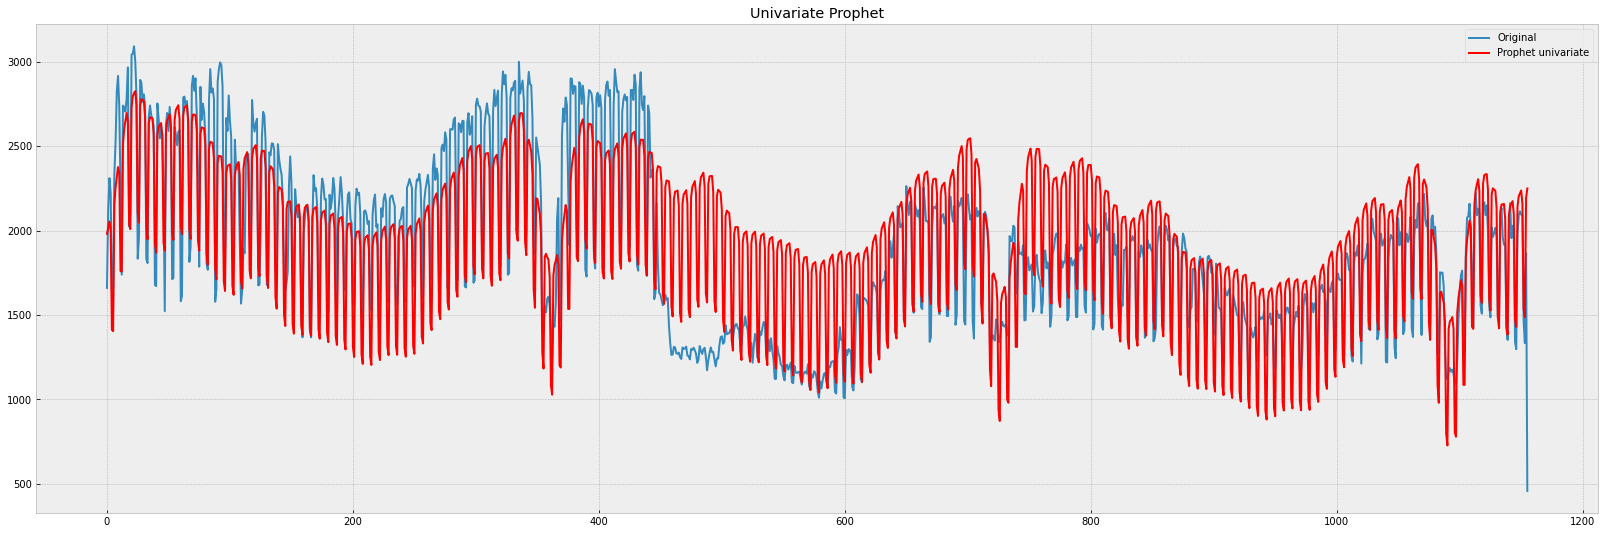

In [39]:
plt.plot(df_test.value.values, label='Original')
plt.plot(yhat.yhat, color='red', label='Prophet univariate')
plt.title('Univariate Prophet')
plt.legend()
plt.savefig("drive/MyDrive/Colab Notebooks/EnergyData/Preprocessed/"+building+"_Daily_Univariate_Prophet.PNG")

# Multivariate time series forecasting

In [42]:
# ADD time features to our model
def create_time_features(df, target=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    # df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    # df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['sin_day'] = np.sin(df['dayofyear'])
    df['cos_day'] = np.cos(df['dayofyear'])
    X = df.drop(['date'], axis=1)
    if target:
        y = df[target]
        X = X.drop([target], axis=1)
        return X, y

    return X

In [ ]:
X_train_df, y_train = create_time_features(df_training, target='value')
X_test_df, y_test = create_time_features(df_test, target='value')

scaler = MinMaxScaler()
scaler.fit(X_train_df)  # No cheating, never scale on the training+test!
X_train = scaler.transform(X_train_df)
X_test = scaler.transform(X_test_df)

X_train_df = pd.DataFrame(X_train, columns=X_train_df.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test_df.columns)

# Tree models

### XGBoost

In [44]:
import xgboost as xgb

In [45]:
reg = xgb.XGBRegressor(objective='reg:squarederror',
    n_estimators=5000,
    learning_rate=0.1,
    subsample=0.5,
    colsample_bytree=1, 
    max_depth=7,
)

reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=50, verbose=False)  # Change verbose to True if you want to see it train
yhat = reg.predict(X_test)
resultsDict['XGBoost'] = evaluate(df_test.value, yhat)
predictionsDict['XGBoost'] = yhat

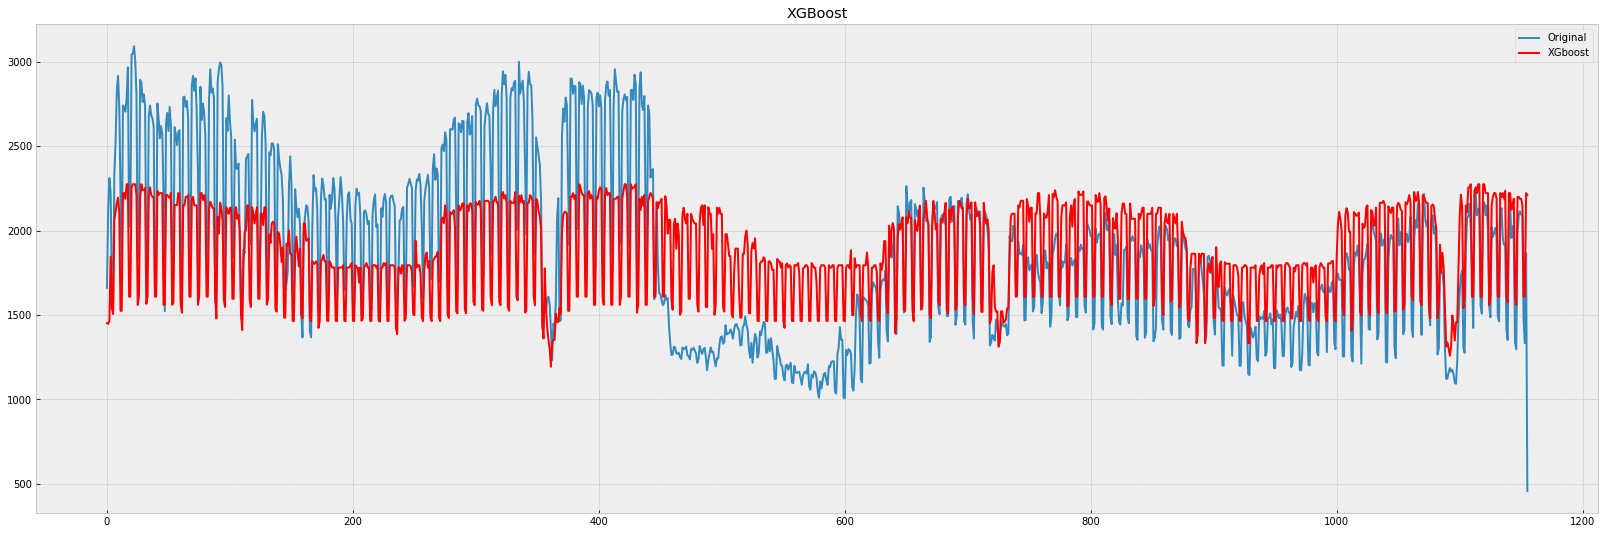

In [46]:
plt.plot(df_test.value.values, label='Original')
plt.plot(yhat, color='red', label='XGboost')
plt.title('XGBoost')
plt.legend()
plt.savefig("drive/MyDrive/Colab Notebooks/EnergyData/Preprocessed/"+building+"_Daily_Elec_XGB.PNG")

### Lightgbm
A tree gradient boosting model by microsoft

In [47]:
import lightgbm as lgb

In [48]:
lightGBM = lgb.LGBMRegressor(boosting_type='gbdt',
    n_estimators=5000,
    learning_rate=0.1,
    subsample=0.5,
    colsample_bytree=1, 
    max_depth=24,
)
lightGBM.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=50, verbose=False)
yhat1 = lightGBM.predict(X_test)
resultsDict['Lightgbm'] = evaluate(df_test.value, yhat1)
predictionsDict['Lightgbm'] = yhat1

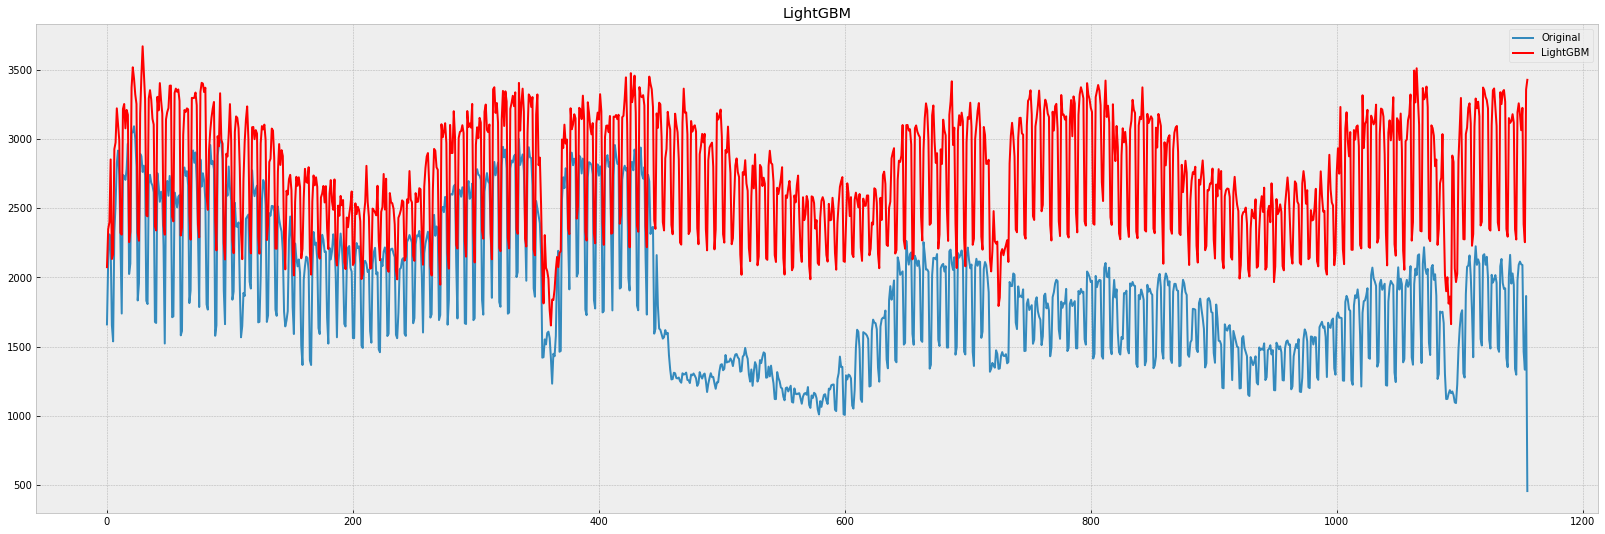

In [49]:
plt.plot(df_test.value.values, label='Original')
plt.plot(yhat1, color='red', label='LightGBM')
plt.title("LightGBM")
plt.legend()
plt.savefig("drive/MyDrive/Colab Notebooks/EnergyData/Preprocessed/"+building+"_Daily_Elec_LGB.PNG")

### Prophet multivariate

In [50]:
prophet = Prophet(
    growth='linear',
    seasonality_mode='multiplicative',
    daily_seasonality=True,
).add_country_holidays(country_name='UK')


for col in prophet_training.columns:
    if col not in ["ds", "y"]:
        prophet.add_regressor(col)

In [51]:
prophet.fit(prophet_training)
yhat2 = prophet.predict(prophet_test)
resultsDict['Prophet multivariate'] = evaluate(y_test, yhat2.yhat.values)
predictionsDict['Prophet multivariate'] = yhat2.yhat.values

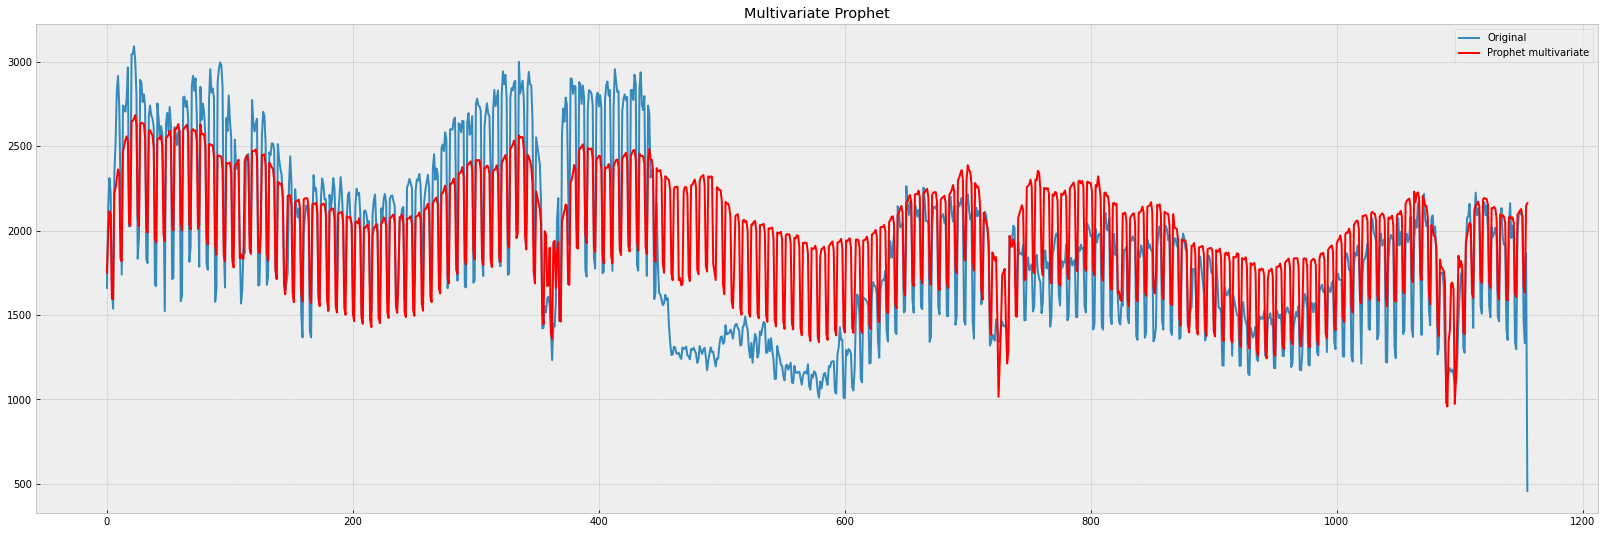

In [52]:
plt.plot(df_test.value.values, label='Original')
plt.plot(yhat2.yhat, color='red', label='Prophet multivariate')
plt.title("Multivariate Prophet")
plt.legend()
plt.savefig("drive/MyDrive/Colab Notebooks/EnergyData/Preprocessed/"+building+"_Daily_Elec_MultiProphet.PNG")

# Deep learning
### Tensorlfow LSTM
LSTM are a special type of neural network architecture, you can read more on this here

We will be trying a LSTM model for our benchmark but we will need to reshape our data to provide the network a window of previous samples (past days data) for each y target value. Find the code here

In [53]:
# For our dl model we will create windows of data that will be feeded into the datasets, for each timestemp T we will append the data from T-7 to T to the Xdata with target Y(t)
BATCH_SIZE = 64
BUFFER_SIZE = 100
WINDOW_LENGTH = 30


def window_data(X, Y, window=7):
    '''
    The dataset length will be reduced to guarante all samples have the window, so new length will be len(dataset)-window
    '''
    x = []
    y = []
    for i in range(window-1, len(X)):
        x.append(X[i-window+1:i+1])
        y.append(Y[i])
    return np.array(x), np.array(y)


# Since we are doing sliding, we need to join the datasets again of train and test
X_w = np.concatenate((X_train, X_test))
y_w = np.concatenate((y_train, y_test))

X_w, y_w = window_data(X_w, y_w, window=WINDOW_LENGTH)
X_train_w = X_w[:-len(X_test)]
y_train_w = y_w[:-len(X_test)]
X_test_w = X_w[-len(X_test):]
y_test_w = y_w[-len(X_test):]

# Check we will have same test set as in the previous models, make sure we didnt screw up on the windowing
print(f"Test set equal: {np.array_equal(y_test_w,y_test)}")

train_data = tf.data.Dataset.from_tensor_slices((X_train_w, y_train_w))
# train_data = train_data.cache().batch(BATCH_SIZE).repeat() #without shuffle
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((X_test_w, y_test_w))
val_data = val_data.batch(BATCH_SIZE).repeat()

Test set equal: True


In [54]:
dropout = 0.2
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(
        50, input_shape=X_train_w.shape[-2:], dropout=dropout),
    tf.keras.layers.Dense(50),
    tf.keras.layers.Dense(50),
    tf.keras.layers.Dense(1)
])

# simple_lstm_model = Sequential()
# simple_lstm_model.add(LSTM(units=64, activation='relu', input_shape=X_train_w.shape[-2:], return_sequences=True))
# simple_lstm_model.add(Dropout(rate=0.2))
# simple_lstm_model.add(LSTM(units=64, activation='relu'))
# simple_lstm_model.add(Dropout(rate=0.2))
# simple_lstm_model.add(Dense(units=1))
simple_lstm_model.summary()

simple_lstm_model.compile(optimizer='adam', loss='mae')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                12400     
                                                                 
 dense (Dense)               (None, 50)                2550      
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 17,551
Trainable params: 17,551
Non-trainable params: 0
_________________________________________________________________


In [55]:
EVALUATION_INTERVAL = 500
EPOCHS = 20

model_history = simple_lstm_model.fit(train_data, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_data, validation_steps=50)

Epoch 1/20
500/500 [==============================] - 15s 22ms/step - loss: 964.0779 - val_loss: 681.6954
Epoch 2/20
500/500 [==============================] - 10s 20ms/step - loss: 497.5244 - val_loss: 725.5446
Epoch 3/20
500/500 [==============================] - 10s 20ms/step - loss: 497.5173 - val_loss: 787.2856
Epoch 4/20
500/500 [==============================] - 10s 19ms/step - loss: 495.0251 - val_loss: 876.8594
Epoch 5/20
500/500 [==============================] - 10s 20ms/step - loss: 494.1366 - val_loss: 958.7944
Epoch 6/20
500/500 [==============================] - 10s 20ms/step - loss: 494.3059 - val_loss: 998.3529
Epoch 7/20
500/500 [==============================] - 10s 20ms/step - loss: 492.3078 - val_loss: 1007.3652
Epoch 8/20
500/500 [==============================] - 10s 20ms/step - loss: 485.5498 - val_loss: 989.2215
Epoch 9/20
500/500 [==============================] - 10s 19ms/step - loss: 472.8904 - val_loss: 898.8784
Epoch 10/20
500/500 [========================

In [56]:
yhat3 = simple_lstm_model.predict(X_test_w).reshape(1, -1)[0]
resultsDict['Tensorflow simple LSTM'] = evaluate(y_test, yhat3)
predictionsDict['Tensorflow simple LSTM'] = yhat3

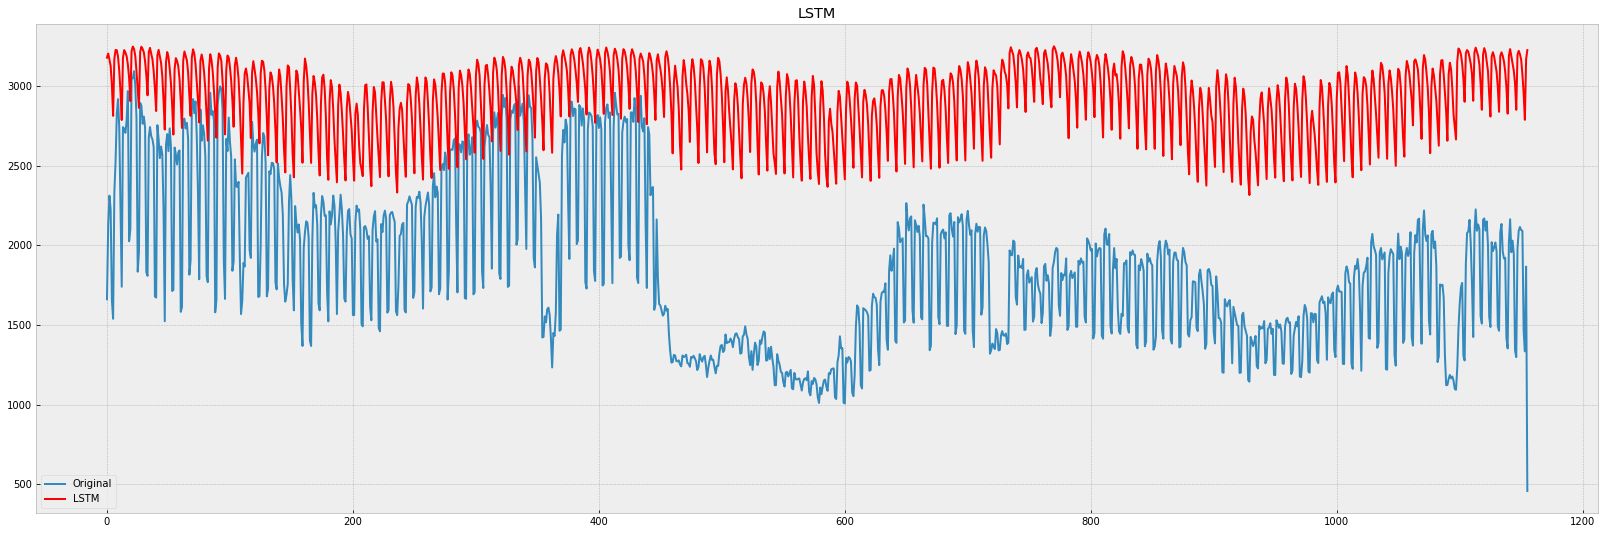

In [57]:
plt.plot(df_test.value.values, label='Original')
plt.plot(yhat3, color='red', label='LSTM')
plt.title('LSTM')
plt.legend()
plt.savefig("drive/MyDrive/Colab Notebooks/EnergyData/Preprocessed/"+building+"_Daily_Elec_LSTM.PNG")

# Ensembling
Ensembling refers to combine multiple models to achieve a better performance, most of the time this only makes sense when models have similar performance but predict values differently so we try to get the best of each model.

We will pick our 3 top performing models and look at the correlation of their residuals, the less correlated the better

In [58]:
models = ['Tensorflow simple LSTM',
          'Lightgbm',
          'XGBoost']
resis = pd.DataFrame(data={k: df_test.value.values -
                     v for k, v in predictionsDict.items()})[models]
corr = resis.corr()
print("Residuals correlation")
corr.style.background_gradient(cmap='coolwarm')

Residuals correlation


,Tensorflow simple LSTM,Lightgbm,XGBoost
Tensorflow simple LSTM,1.000000,0.756264,0.914597
Lightgbm,0.756264,1.000000,0.896089
XGBoost,0.914597,0.896089,1.000000


We can see how both tree models are a bit similar ~0.87 but quite different from the Deep Learning model with corr ~0.9 for LightGBM and corr ~0.87 for XGBoost. In this case it would really make sense to ensemble the methods and see how they behave. The most reasonable combinations to try would be

- XGboost + Tensorflow
- XGBoost + Lightgbm
- Lightgbm + Tensorflow
- XGBoost + Lightgbm + Tensorflow
We will just sum the predictions of each model with similar weights (0.5 if two models, 0.333 if three)

In [59]:
predictionsDict['EnsembleXG+LIGHT'] = (predictionsDict['XGBoost'] + predictionsDict['Lightgbm'])/2
resultsDict['EnsembleXG+LIGHT'] = evaluate(df_test.value.values, predictionsDict['EnsembleXG+LIGHT'])

predictionsDict['EnsembleXG+LIGHT+TF'] = (predictionsDict['XGBoost'] + predictionsDict['Lightgbm'] + predictionsDict['Tensorflow simple LSTM'])/3
resultsDict['EnsembleXG+LIGHT+TF'] = evaluate(df_test.value.values, predictionsDict['EnsembleXG+LIGHT+TF'])

predictionsDict['EnsembleLIGHT+TF'] = (predictionsDict['Lightgbm'] + predictionsDict['Tensorflow simple LSTM'])/2
resultsDict['EnsembleLIGHT+TF'] = evaluate(df_test.value.values, predictionsDict['EnsembleLIGHT+TF'])

predictionsDict['EnsembleXG+TF'] = (predictionsDict['XGBoost'] + predictionsDict['Tensorflow simple LSTM'])/2
resultsDict['EnsembleXG+TF'] = evaluate(df_test.value.values, predictionsDict['EnsembleXG+TF'])

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:245: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  "'color' and 'colormap' cannot be used simultaneously. Using 'color'"
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/style.py:124: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  "'color' and 'colormap' cannot be used simultaneously. Using 'color'"
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:245: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  "'color' and 'colormap' cannot be used simultaneously. Using 'color'"
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/style.py:124: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  "'color' and 'colormap' cannot be used simultaneously. Using 'color'"
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib

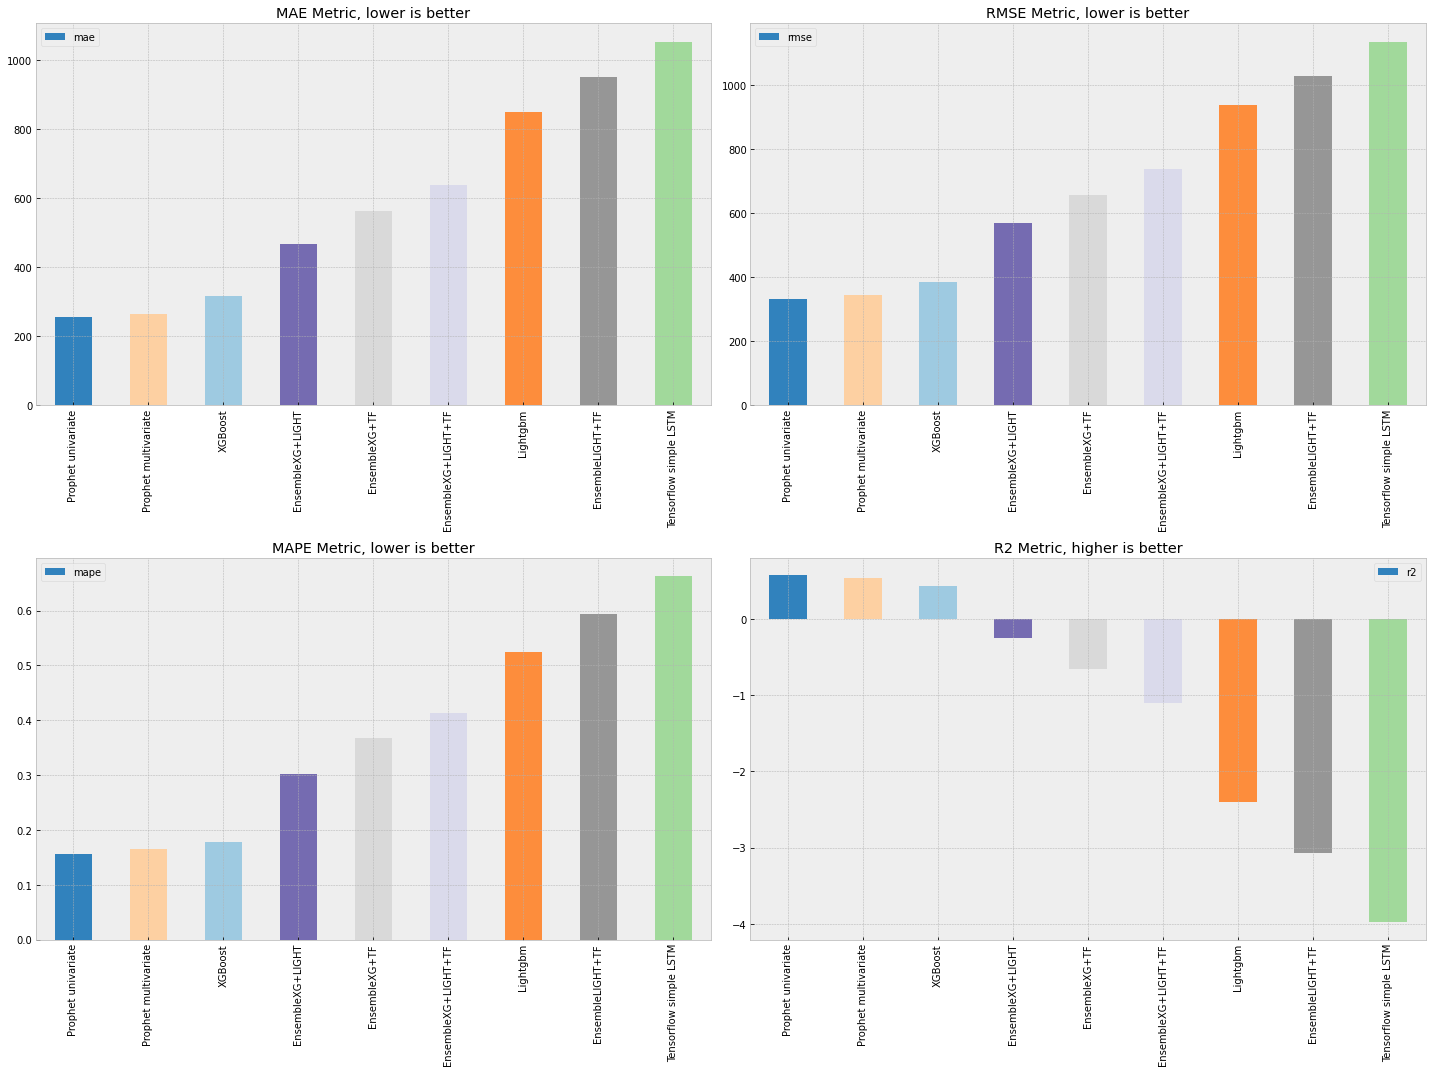

In [60]:
bar_metrics(resultsDict)

In [61]:
df = pd.DataFrame.from_dict(resultsDict).transpose().iloc[::-1]
df = df.round(2)
df.to_csv("drive/MyDrive/Colab Notebooks/EnergyData/Preprocessed/"+building+"_results_summary.csv")